## **IMPORTING ALL MODULES**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
import xgboost as xgb
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

## **MOUNTING GOOGLE DRIVE**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **LOADING THE CSV FILE INTO THE DATAFRAME**

In [3]:
df= pd.read_csv('/content/drive/MyDrive/ALDA Homework/vehicles.csv')
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


## **DATA PRE-PROCESSING**

REMOVING COLUMNS THAT ARE NOT IMPORTANT SUCH AS URLs/IDs.

In [4]:
df=df.drop(['id', 'url', 'region_url', 'lat', 'long', 'county', 'image_url', 'description', 'size', 'VIN'], axis=1)
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN


FINDING HOW MANY NAN VALUES ARE PRESENT IN EACH COLUMN

In [5]:
df_copy = df
df_copy = df_copy.dropna()
df_copy.shape

(115988, 16)

After dropna, almost of 73% our data is getting deleted. Hence we look at all attributes individually

In [6]:
df.isna().sum()

region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
type             92858
paint_color     130203
state                0
posting_date        68
dtype: int64

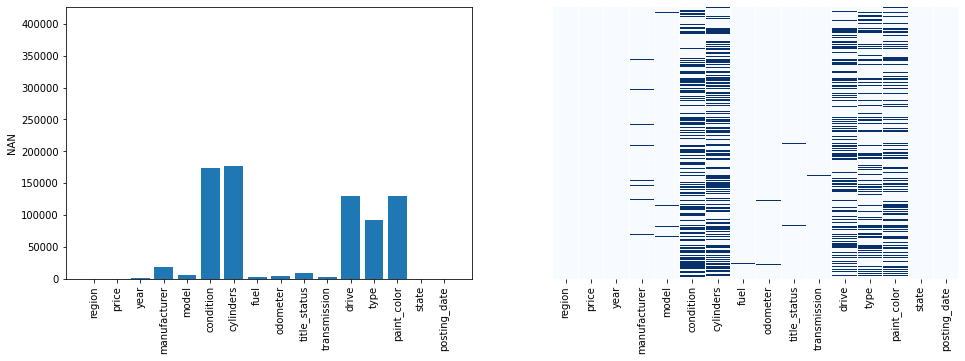

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.bar(df.columns,df.isna().sum())
ax1.set_ylabel('NAN')
ax1.set_ylim(0,df.shape[0])
ax1.tick_params('x',labelrotation=90)
sns.heatmap(df.isna(),yticklabels=False,cbar=False, cmap='Blues',ax=ax2)
plt.show()

### **CREATING BOX PLOTS FOR OUTLIERS**

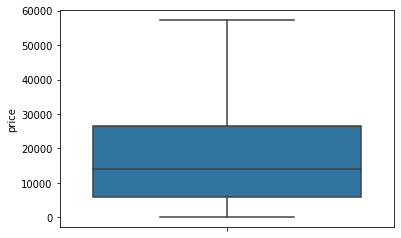

In [8]:
sns.boxplot(y='price', data=df,showfliers=False)

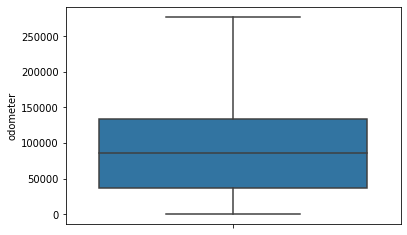

In [9]:
sns.boxplot(y='odometer', data= df,showfliers=False);

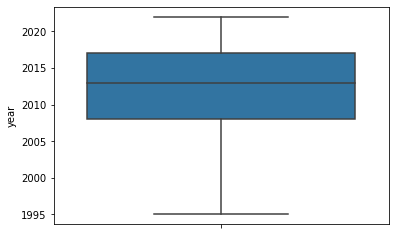

In [10]:
sns.boxplot(y='year', data= df,showfliers=False);

REMOVING ROWS WITH PRICES ABOVE 30000 and PRICES BELOW 4000

We consider prices between the 20th and 80th percentile

In [11]:
filter_price = df[df['price'] > 4000]
filter_price = df[df['price'] < 30000]

REMOVING ALL VEHICLES WITH YEAR<1990

We only see relevant data for predictions for years greater than 1990

In [12]:
filter_year = filter_price[filter_price['year'] > 1990]


FINDING THE BETTER ATTRIBUTE IN CONDITION AND TITLE STATUS

In [13]:
df['title_status'].value_counts()

clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: title_status, dtype: int64

In [14]:
df['condition'].value_counts()

good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: condition, dtype: int64

SELECTING CONDITION OVER TITLE STATUS

As both of these attributes help in getting informaton about the current state of the car, 

In [15]:
title_status_removed=filter_year.drop(['title_status'], axis = 1) 

REMOVING ROWS WITH ODOMETER READINGS BELOW 30000 and ABOVE 190000

In [16]:
odometer_removed = title_status_removed[title_status_removed['odometer'] > 30000]
odometer_removed = title_status_removed[title_status_removed['odometer'] < 190000]

FINDING ALL NAN VALUES

In [17]:
odometer_removed.isna().sum()

region               0
price                0
year                 0
manufacturer      9608
model             2765
condition       125339
cylinders       125182
fuel              1728
odometer             0
transmission      1227
drive            91687
type             64892
paint_color      93256
state                0
posting_date         0
dtype: int64

REMOVING ALL NAN VALUES

In [18]:
drop_all_nan = odometer_removed.dropna()

### **LABEL ENCODING CATEGORICAL FEATURES**

In [19]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = drop_all_nan.columns.values.tolist()
for col in features:
    if drop_all_nan[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in drop_all_nan.columns:
        le = LabelEncoder()
        le.fit(list(drop_all_nan[col].astype(str).values))
        drop_all_nan[col] = le.transform(list(drop_all_nan[col].astype(str).values))
drop_all_nan.dtypes

<ipython-input-19-e4ce0e9f843f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_all_nan[col] = le.transform(list(drop_all_nan[col].astype(str).values))


region            int64
price             int64
year            float64
manufacturer      int64
model             int64
condition         int64
cylinders         int64
fuel              int64
odometer        float64
transmission      int64
drive             int64
type              int64
paint_color       int64
state             int64
posting_date      int64
dtype: object

## **EXPLORATORY DATA ANALYSIS**

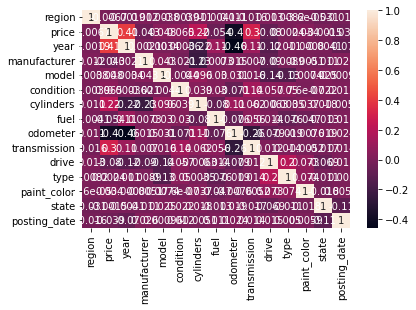

In [20]:
sns.heatmap(drop_all_nan.corr(), annot = True)

REMOVING COLUMNS WITH LITTLE TO NO CORRELATION

In [21]:
nocorelation = drop_all_nan.drop(['region','state','posting_date','paint_color'], axis=1)

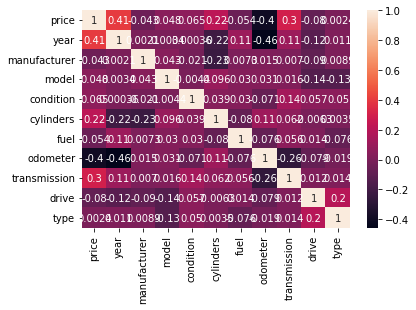

In [22]:
sns.heatmap(nocorelation.corr(), annot = True)

### **FINAL DATAFRAME**

In [23]:
finaldf=nocorelation

In [24]:
finaldf.describe()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type
count,83645.000000,83645.000000,83645.000000,83645.000000,83645.000000,83645.000000,83645.000000,83645.000000,83645.000000,83645.000000,83645.000000
mean,11647.747612,2010.646578,16.939638,4404.498547,1.089031,4.397645,1.975013,103302.892104,0.182175,0.811298,5.952131
std,8076.964796,5.482266,10.867618,2440.458699,1.172601,1.272819,0.412605,46659.349357,0.517634,0.740065,4.152191
min,0.000000,1991.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5500.000000,2007.000000,8.000000,2342.000000,0.000000,3.000000,2.000000,70000.000000,0.000000,0.000000,0.000000
50%,9900.000000,2012.000000,14.000000,4313.000000,0.000000,5.000000,2.000000,106000.000000,0.000000,1.000000,8.000000
75%,16972.000000,2015.000000,27.000000,6605.000000,2.000000,5.000000,2.000000,140000.000000,0.000000,1.000000,9.000000
max,29999.000000,2022.000000,38.000000,8758.000000,5.000000,7.000000,4.000000,189995.000000,2.000000,2.000000,12.000000


SAVING DATAFRAME TO CSV

In [25]:
finaldf.to_csv('/content/drive/MyDrive/cleaned_data.csv', encoding='utf-8', index=False)

## **MODEL BUILDING AND EVALUATION**

STANDARD SCALING

In [26]:
scaler = StandardScaler()
finaldf= pd.DataFrame(scaler.fit_transform(finaldf), columns = finaldf.columns)

SPLITTING DATASET INTO TRAINING AND TESTING SET

In [27]:
y_train = finaldf['price']
X_train = finaldf.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

### **LINEAR REGRESSION**

In [28]:
logr = LinearRegression()
lreg=logr.fit(X_train,y_train)

In [29]:
y_predicted = logr.predict(X_test)

PERFORMANCE METRICS

In [30]:
print("R^2 : ", r2_score(y_test, y_predicted))
print("MAE :", mean_absolute_error(y_test,y_predicted))
print("Accuracy:", 1-mean_absolute_error(y_test,y_predicted))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_predicted)))

R^2 :  0.3475227269792087
MAE : 0.5767477018763312
Accuracy: 0.4232522981236688
RMSE: 0.8022921712401472


COEFFICIENTS AND INTERCEPTS

In [31]:
lreg.coef_

array([ 0.35162047,  0.02392079,  0.01661742,  0.01718584,  0.30433163,
       -0.09684834, -0.23360226,  0.18727589, -0.05240921, -0.004136  ])

In [32]:
lreg.intercept_

0.0016439510683561058

## **SUPPORT VECTOR REGRESSOR**

1. USING RBF KERNEL

In [33]:
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [34]:
y_predictedSVR = svr.predict(X_test)

PERFORMANCE METRICS

In [35]:
print("R^2 : ", r2_score(y_test, y_predictedSVR))
print("MAE :", mean_absolute_error(y_test,y_predictedSVR))
print("Accuracy:", 1-mean_absolute_error(y_test,y_predictedSVR))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_predictedSVR)))

R^2 :  0.5649197398371225
MAE : 0.39805215931277865
Accuracy: 0.6019478406872214
RMSE: 0.655140653615331


2. USING POLYNOMIAL KERNEL

In [36]:
svrs = SVR(kernel='poly')
svrs.fit(X_train, y_train)

SVR(kernel='poly')

In [37]:
y_predictedSVRs = svrs.predict(X_test)

PERFORMANCE METRICS

In [38]:
print("R^2 : ", r2_score(y_test, y_predictedSVRs))
print("MAE :", mean_absolute_error(y_test,y_predictedSVRs))
print("Accuracy:", 1-mean_absolute_error(y_test,y_predictedSVRs))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_predictedSVRs)))

R^2 :  0.3708608719928296
MAE : 0.5243248490451257
Accuracy: 0.47567515095487434
RMSE: 0.7878131177789056


## **RANDOM FOREST REGRESSOR**

In [39]:
random_forest = RandomForestRegressor()
rffit=random_forest.fit(X_train, y_train)

In [40]:
y_predictedRFR = rffit.predict(X_test)

PERFORMANCE METRICS

In [41]:
print("R^2 : ", r2_score(y_test, y_predictedRFR))
print("MAE :", mean_absolute_error(y_test,y_predictedRFR))
print("Accuracy:", 1-mean_absolute_error(y_test,y_predictedRFR))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_predictedRFR)))

R^2 :  0.7792832706304312
MAE : 0.2562802547249536
Accuracy: 0.7437197452750464
RMSE: 0.4666244444796711


## **ANN USING LSTM**

### LONG-SHORT TERM MEMORY

SPLITTING DATASET TO TRAINING, VALIDATION AND TESTING

In [42]:
y_train = finaldf['price']
X_train = finaldf.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_val = pd.DataFrame(scaler.fit_transform(X_val), columns = X_val.columns)
X_train11 = []
y_train11 = []
X_train11, y_train11 = np.array(X_train), np.array(y_train)
X_train11 = np.reshape(X_train11, (X_train11.shape[0], X_train11.shape[1], 1))
X_test11 = []
y_test11 = []
X_test11, y_test11 = np.array(X_test), np.array(y_test)
X_test11 = np.reshape(X_test11, (X_test11.shape[0], X_test11.shape[1], 1))
X_val11 = []
y_val11 = []
X_val11, y_val11 = np.array(X_val), np.array(y_val)
X_val11 = np.reshape(X_val11, (X_val11.shape[0], X_val11.shape[1], 1))

CREATING THE MODEL

In [43]:
model3 = Sequential()
model3.add(LSTM(units=128,return_sequences=True,input_shape=(X_train11.shape[1], 1)))
model3.add(Dropout(0.2))
model3.add(LSTM(64, return_sequences=False))
model3.add(Dense(32))
model3.add(Dense(1))
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [44]:
model3.compile(optimizer='adam',loss='mean_absolute_error')
hist1=model3.fit(X_train11,y_train11,epochs=100,batch_size=32, validation_data=(X_val11,y_val11), validation_batch_size=32)

Epoch 1/100
1673/1673 [==============================] - 21s 7ms/step - loss: 0.5872 - val_loss: 0.5259
Epoch 2/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.5023 - val_loss: 0.4883
Epoch 3/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.4713 - val_loss: 0.4585
Epoch 4/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.4506 - val_loss: 0.4492
Epoch 5/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.4393 - val_loss: 0.4317
Epoch 6/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.4286 - val_loss: 0.4200
Epoch 7/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.4189 - val_loss: 0.4163
Epoch 8/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.4104 - val_loss: 0.4113
Epoch 9/100
1673/1673 [==============================] - 12s 7ms/step - loss: 0.4024 - val_loss: 0.3975
Epoch 10/100
1673/1673 [==============================] - 12s 7m

GENERATING VALIDATION LOSS GRAPH

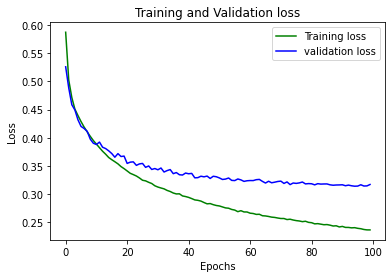

In [45]:
loss_train = hist1.history['loss']
loss_val = hist1.history['val_loss']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TRAINING FOR 93 EPOCHS

In [47]:
y_predictedLSTM1 = model3.predict(X_test11)

523/523 [==============================] - 4s 5ms/step


PERFORMANCE METRICS

In [48]:
print("R^2 : ", r2_score(y_test11, y_predictedLSTM1))
print("MAE :", mean_absolute_error(y_test11,y_predictedLSTM1))
print("Accuracy: ", 1-mean_absolute_error(y_test11,y_predictedLSTM1))
print("RMSE:",np.sqrt(mean_squared_error(y_test11, y_predictedLSTM1)))

R^2 :  0.6741660599264028
MAE : 0.31218352167286845
Accuracy:  0.6878164783271316
RMSE: 0.5669542561475936


## **LIGHT GRADIENT BOOSTING MACHINE**

In [49]:
train_set = lgb.Dataset(X_train, y_train, silent=False)
valid_set = lgb.Dataset(X_test, y_test, silent=False)
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 160,#31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 0.75,
        'max_bin' : 5000,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0    
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=500, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds.
[500]	valid_0's rmse: 0.575919
[1000]	valid_0's rmse: 0.564958
[1500]	valid_0's rmse: 0.564952
[2000]	valid_0's rmse: 0.564952
[2500]	valid_0's rmse: 0.564952
[3000]	valid_0's rmse: 0.564952
[3500]	valid_0's rmse: 0.564952
[4000]	valid_0's rmse: 0.564952
[4500]	valid_0's rmse: 0.564952
[5000]	valid_0's rmse: 0.564952
[5500]	valid_0's rmse: 0.564952
[6000]	valid_0's rmse: 0.564952
[6500]	valid_0's rmse: 0.564952
[7000]	valid_0's rmse: 0.564952
[7500]	valid_0's rmse: 0.564952
[8000]	valid_0's rmse: 0.564952
[8500]	valid_0's rmse: 0.564952
Early stopping, best iteration is:
[954]	valid_0's rmse: 0.564902


In [50]:
y_predictedLGB = modelL.predict(X_test)

PERFORMANCE METRICS

In [51]:
print("R^2 : ", r2_score(y_test, y_predictedLGB))
print("MAE :", mean_absolute_error(y_test,y_predictedLGB))
print("Accuracy:", 1-mean_absolute_error(y_test,y_predictedLGB))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_predictedLGB)))

R^2 :  0.6765205173304519
MAE : 0.3668581173691729
Accuracy: 0.633141882630827
RMSE: 0.5649021528266371


## **XGBOOST**

In [52]:
xgb_clf = xgb.XGBRegressor({'objective': 'reg:squarederror'}) 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(X_train, y_train)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)

[02:14:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.700
Best parameters set: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140, 'reg_lambda': 0.5}


In [53]:
y_predictedXGB = xgb_reg.predict(X_test)

In [54]:
print("R^2 : ", r2_score(y_test, y_predictedXGB))
print("MAE :", mean_absolute_error(y_test,y_predictedXGB))
print("Accuracy:", 1-mean_absolute_error(y_test,y_predictedXGB))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_predictedXGB)))

R^2 :  0.6649887857539656
MAE : 0.36974232719181993
Accuracy: 0.6302576728081801
RMSE: 0.5748830875614813
